# Title Similarity Comparison

Compare note titles from Notion to determine optimal similarity cutoff threshold.

- Pulls titles from Notion
- Generates embeddings using sentence-transformers
- Displays similarity matrix as heatmap
- Allows adding/editing custom titles for testing


In [1]:
"""Setup and imports."""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import ipywidgets as widgets

from recaller.config import get_settings
from recaller.services.notion_client import NotionService
from recaller.services.embedding_service import EmbeddingService
from recaller.services.similarity_engine import SimilarityEngine

# Initialize services
settings = get_settings()
notion = NotionService(token=settings.notion_token, recaller_page_id=settings.notion_page_id)
embedding_service = EmbeddingService(model_name=settings.embedding_model)
similarity_engine = SimilarityEngine(threshold=0.0)  # Use 0 to see all similarities

print("✓ Services initialized")


✓ Services initialized


In [2]:
"""Fetch note titles from Notion."""
print("Fetching notes from Notion...")

# Fetch from Current page
current_notes = notion.fetch_current_notes()
print(f"  Current: {len(current_notes)} notes")

# Fetch from Database
database_notes = notion.fetch_database_notes()
print(f"  Database: {len(database_notes)} notes")

# Combine and extract unique titles
all_notes = current_notes + database_notes
notion_titles = list(set(n.title for n in all_notes if n.title))
notion_titles.sort()

print(f"\n✓ Found {len(notion_titles)} unique titles")
for i, title in enumerate(notion_titles[:10]):
    print(f"  {i+1}. {title}")
if len(notion_titles) > 10:
    print(f"  ... and {len(notion_titles) - 10} more")


Fetching notes from Notion...
  Current: 7 notes
  Database: 0 notes

✓ Found 7 unique titles
  1. AI Fluency: Framework & Foundations
  2. Claude Chrome Extension with Claude Code
  3. Claude Code
  4. Cooking gear brands
  5. Gym: warming up
  6. Learning methods
  7. Places to go


In [4]:
"""Interactive title editor - add, edit, or remove titles."""

# Working list of titles (starts with Notion titles)
titles = notion_titles.copy()

In [5]:
"""Generate embeddings and compute similarity matrix."""
print(f"Generating embeddings for {len(titles)} titles...")

# Generate embeddings for all titles
embeddings = embedding_service.generate_embeddings(titles)
embeddings_matrix = np.stack(embeddings)

Generating embeddings for 7 titles...


In [6]:
print(f"  Embedding shape: {embeddings_matrix.shape}")

# Compute similarity matrix using normalized dot product
norms = np.linalg.norm(embeddings_matrix, axis=1, keepdims=True)
norms = np.where(norms == 0, 1, norms)
normalized = embeddings_matrix / norms
similarity_matrix = np.dot(normalized, normalized.T)

print(f"  Similarity matrix: {similarity_matrix.shape}")
print(f"\n✓ Embeddings computed")
print(f"  Min similarity: {similarity_matrix.min():.3f}")
print(f"  Max similarity (off-diagonal): {np.fill_diagonal(similarity_matrix.copy(), 0) or similarity_matrix[~np.eye(len(titles), dtype=bool)].max():.3f}")


  Embedding shape: (7, 384)
  Similarity matrix: (7, 7)

✓ Embeddings computed
  Min similarity: -0.007
  Max similarity (off-diagonal): 0.680


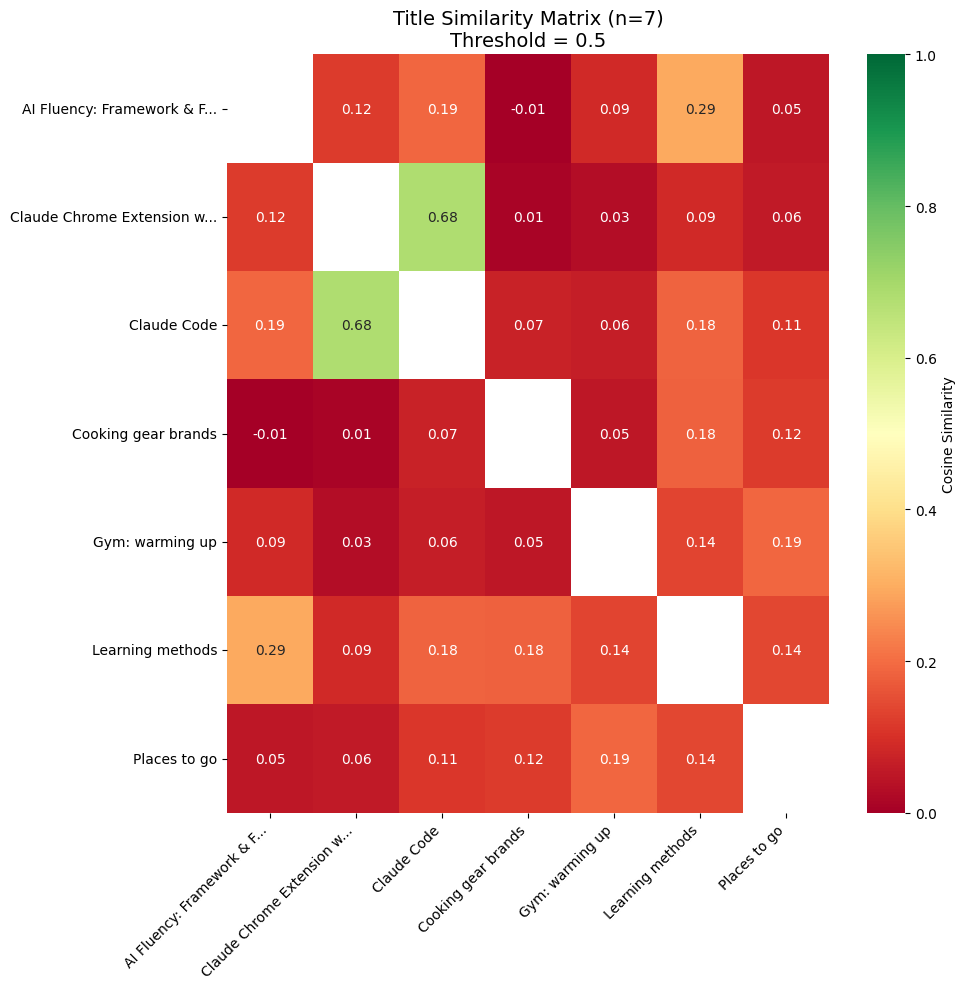


Pairs with similarity ≥ 0.5:
  0.680: Claude Chrome Extension with Claude Code...
         ↔ Claude Code...



In [7]:
"""Visualize similarity matrix as heatmap."""

def plot_similarity_matrix(sim_matrix: np.ndarray, labels: list[str], threshold: float = 0.78):
    """
    Plot similarity matrix as heatmap with threshold line.
    
    Args:
        sim_matrix: NxN similarity matrix
        labels: List of title labels
        threshold: Similarity threshold to highlight
    """
    n = len(labels)
    
    # Truncate labels for display
    short_labels = [t[:25] + "..." if len(t) > 25 else t for t in labels]
    
    # Dynamic figure size based on number of titles
    fig_size = max(10, min(20, n * 0.5))
    
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    
    # Create heatmap
    mask = np.eye(n, dtype=bool)  # Mask diagonal
    sns.heatmap(
        sim_matrix,
        mask=mask,
        annot=n <= 15,  # Only show values if few titles
        fmt='.2f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        xticklabels=short_labels,
        yticklabels=short_labels,
        ax=ax,
        cbar_kws={'label': 'Cosine Similarity'}
    )
    
    ax.set_title(f'Title Similarity Matrix (n={n})\nThreshold = {threshold}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Show pairs above threshold
    print(f"\n{'='*60}")
    print(f"Pairs with similarity ≥ {threshold}:")
    print(f"{'='*60}")
    
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            if sim_matrix[i, j] >= threshold:
                pairs.append((sim_matrix[i, j], labels[i], labels[j]))
    
    pairs.sort(reverse=True)
    
    if pairs:
        for sim, t1, t2 in pairs:
            print(f"  {sim:.3f}: {t1[:40]}...")
            print(f"         ↔ {t2[:40]}...")
            print()
    else:
        print("  No pairs above threshold")
    
    return pairs

# Plot with default threshold
pairs_above = plot_similarity_matrix(similarity_matrix, titles, threshold=settings.similarity_threshold)


In [ ]:
"""Interactive threshold explorer."""

def explore_threshold(threshold: float):
    """
    Explore different thresholds and see which pairs would be matched.
    
    Args:
        threshold: Similarity threshold to test
    """
    n = len(titles)
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i, j] >= threshold:
                pairs.append((similarity_matrix[i, j], titles[i], titles[j]))
    
    pairs.sort(reverse=True)
    
    clear_output(wait=True)
    print(f"Threshold: {threshold:.2f}")
    print(f"Pairs matched: {len(pairs)}")
    print("=" * 70)
    
    if pairs:
        for sim, t1, t2 in pairs[:20]:  # Show top 20
            print(f"\n  {sim:.3f}")
            print(f"    • {t1[:60]}{'...' if len(t1) > 60 else ''}")
            print(f"    • {t2[:60]}{'...' if len(t2) > 60 else ''}")
        if len(pairs) > 20:
            print(f"\n  ... and {len(pairs) - 20} more pairs")
    else:
        print("\n  No pairs above this threshold")

# Interactive slider
threshold_slider = widgets.FloatSlider(
    value=settings.similarity_threshold,
    min=0.5,
    max=0.95,
    step=0.01,
    description='Threshold:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='400px')
)

display(widgets.HTML("<h3>🎚️ Threshold Explorer</h3>"))
widgets.interact(explore_threshold, threshold=threshold_slider)


In [ ]:
"""Similarity distribution analysis to find optimal cutoff."""

# Get all pairwise similarities (excluding diagonal)
n = len(titles)
off_diagonal_sims = []
for i in range(n):
    for j in range(i+1, n):
        off_diagonal_sims.append(similarity_matrix[i, j])

off_diagonal_sims = np.array(off_diagonal_sims)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(off_diagonal_sims, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=settings.similarity_threshold, color='red', linestyle='--', 
                label=f'Current threshold ({settings.similarity_threshold})', linewidth=2)
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Pairwise Similarities')
axes[0].legend()

# Cumulative distribution (how many pairs above each threshold)
thresholds = np.arange(0.5, 0.96, 0.01)
counts = [np.sum(off_diagonal_sims >= t) for t in thresholds]

axes[1].plot(thresholds, counts, 'b-', linewidth=2)
axes[1].axvline(x=settings.similarity_threshold, color='red', linestyle='--', 
                label=f'Current threshold ({settings.similarity_threshold})', linewidth=2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Number of Pairs Above Threshold')
axes[1].set_title('Pairs Matched vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n📊 Similarity Statistics:")
print(f"  Total pairs: {len(off_diagonal_sims)}")
print(f"  Mean similarity: {off_diagonal_sims.mean():.3f}")
print(f"  Median similarity: {np.median(off_diagonal_sims):.3f}")
print(f"  Std deviation: {off_diagonal_sims.std():.3f}")
print(f"\n  Percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"    {p}th percentile: {np.percentile(off_diagonal_sims, p):.3f}")


In [ ]:
"""Compare any two titles directly."""

def compare_two_titles(title1_idx: int, title2_idx: int):
    """
    Compare two specific titles and show their similarity.
    
    Args:
        title1_idx: Index of first title
        title2_idx: Index of second title
    """
    if title1_idx == title2_idx:
        print("⚠️ Select two different titles")
        return
    
    t1, t2 = titles[title1_idx], titles[title2_idx]
    sim = similarity_matrix[title1_idx, title2_idx]
    
    print(f"Similarity: {sim:.4f}")
    print("=" * 60)
    print(f"\nTitle 1: {t1}")
    print(f"\nTitle 2: {t2}")
    print(f"\n{'✅ WOULD MERGE' if sim >= settings.similarity_threshold else '❌ WOULD NOT MERGE'} (threshold: {settings.similarity_threshold})")

# Create dropdowns for title selection
options = [(f"{i}: {t[:40]}...", i) if len(t) > 40 else (f"{i}: {t}", i) for i, t in enumerate(titles)]

title1_dd = widgets.Dropdown(options=options, value=0, description="Title 1:", layout=widgets.Layout(width='500px'))
title2_dd = widgets.Dropdown(options=options, value=min(1, len(titles)-1), description="Title 2:", layout=widgets.Layout(width='500px'))

display(widgets.HTML("<h3>🔍 Compare Two Titles</h3>"))
widgets.interact(compare_two_titles, title1_idx=title1_dd, title2_idx=title2_dd)
